In [11]:
%load_ext autoreload
%autoreload 2

from pps import PredatorPreySwarmEnv
import json
import matplotlib.pyplot as plt
import supersuit as ss
from stable_baselines3 import PPO
from tqdm import tqdm

with open("config/eval_params.json") as f:
    config = json.load(f)

def display_results(results):
    num_subplots = len(results[0])
    fig, axs = plt.subplots(num_subplots, 1)
    fig.tight_layout()
    for i, metric in enumerate(results[0]):
        axs[i].set_ylim(0, 1.1)
        axs[i].plot([r[metric] for r in results])
        axs[i].set_title(metric)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 15000/15000 [1:05:53<00:00,  3.79it/s]  


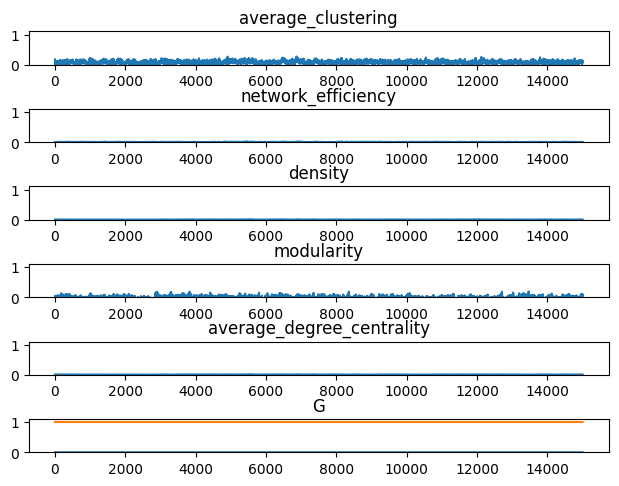

In [10]:
# NO PRETRAINED MODEL
results = []
env = PredatorPreySwarmEnv(config, metrics_in_info=True)
max_ep_len = env._ep_len

obs, info = env.reset()
for _ in tqdm(range(max_ep_len), desc="Evaluationg episode"):
    # img = env.render(mode='rgb_array')    
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    obs, rew, term, trunc, info = env.step(actions)
    results.append(info[0])
env.close()

display_results(results)

Using custom config
Some particles are overlapped at the initial time !


Evaluationg episode: 100%|██████████| 10000/10000 [50:10<00:00,  3.32it/s]  


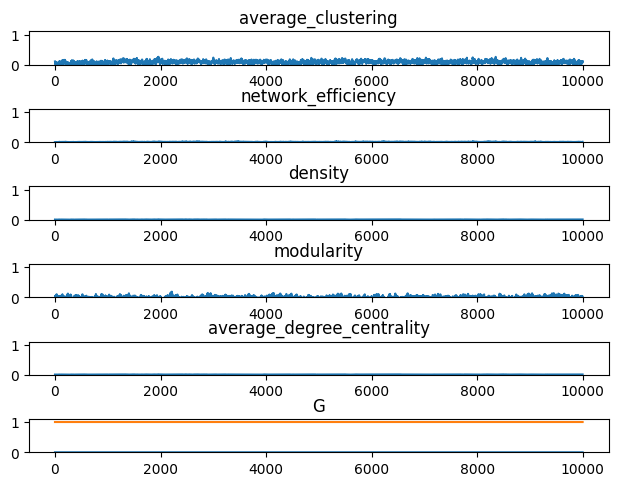

In [12]:
# WITH PRETRAINED MODEL
results = []
model = PPO.load("models/test1.zip")
# model = PPO.load("models/evade.zip")
env = PredatorPreySwarmEnv(config, metrics_in_info=True)
max_ep_len = env._ep_len

env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 1, base_class="stable_baselines3")

obs = env.reset()
for _ in tqdm(range(max_ep_len), desc="Evaluationg episode"):
    # img = env.render(mode="rgb_array")
    action, _ = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    # print(info[0])
    results.append(info[0])
env.close()

display_results(results)